In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from time import time
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
from typing import List
from statistics import mode

In [2]:
names = [  
#         'GradientBoostingRegressor',
#         'Nearest Neighbors',
#         'AdaBoostClassifier',
        'RandomForest',
#         "Linear SVM",
        "RBF SVM",
        "Decision Tree",
#         'RUSBoost',
#         'Shrinkage LDA',
        ]

# build classifiers
classifiers = [
#             GradientBoostingRegressor(random_state=1),
#             KNeighborsClassifier(n_neighbors=5),
#             AdaBoostClassifier(n_estimators=400, learning_rate = 0.6),
            RandomForestClassifier(n_estimators=300, max_features = "sqrt", oob_score = True),
#             SVC(kernel="linear", C=0.025),
            SVC(gamma=2, C=1),
            DecisionTreeClassifier(),
#             RUSBoostClassifier(n_estimators = 200, random_state=1),
#             LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
              ]

def most_common(List):
    return(mode(List))

# prediction_first is the prediction of the classifier that has higher accuracy
def time_majority_voting(prediction_first : List, prediction_second : List) -> List:
    res = []
    majority = most_common(prediction_first)
    print("Majority y is", majority)
    if len(prediction_first) != len(prediction_second):
        raise Exception("length do not match")
    for i in range(len(prediction_first)):
        node_one = prediction_first[i]
        node_two = prediction_second[i]
        if node_one == node_two:
            res.append(node_one)
        else:
            res.append(majority)
    return res

def calculate_accuracy(y_one : List, y_two : List) -> float:
    if len(y_one) != len(y_two):
        raise Exception("length do not match")
    numerator = 0
    for i in range(len(y_one)):
        first = y_one[i]
        second = y_two[i]
        if first == second:
            numerator += 1
    return float(numerator) / float(len(y_two))

In [3]:
df = pd.read_csv("EEGEyeNet-data.csv", header=None)
df=df.rename({'259':'subject_id'}, axis='columns')
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
col_names = ["y", "subject_id"]
col_names.extend(cols[2:])
df.columns = col_names

In [4]:
subject_1_data = df[df["subject_id"] == 1]
subject_1_data

,y,subject_id,0,1,2,3,4,5,6,7,...,248,249,250,251,252,253,254,255,256,257
0,0.0,1.0,-0.614956,-0.895352,-1.211214,-1.177657,-1.303933,-1.839487,-2.142546,-1.055771,...,1.864200,2.960007,2.591124,2.458646,1.564191,1.749306,1.866156,1.838410,2.684922,2.642616
1,1.0,1.0,2.168588,2.180634,2.853209,3.074311,-2.715321,-2.168503,-2.137354,2.124838,...,3.936013,4.564512,3.631178,5.033731,4.133299,4.495341,3.519985,2.407326,4.702723,0.718291
2,1.0,1.0,2.031542,1.829667,1.837323,1.916588,1.493518,-1.487775,-0.780526,1.847879,...,2.991593,2.791708,0.832749,1.564096,1.065903,2.927388,4.770316,1.696444,1.603354,0.792276
3,1.0,1.0,-2.440350,2.711351,2.740857,2.748624,2.717895,2.703553,2.374919,2.532810,...,3.321059,2.560724,1.134760,3.845342,3.955975,2.047008,2.898161,1.342468,1.813402,3.169124
4,1.0,1.0,1.186138,1.446603,1.972229,2.060974,2.529160,2.819480,3.049594,1.653412,...,4.363304,4.498397,4.880619,5.112298,4.164458,3.799994,4.311713,1.155651,3.506095,2.411114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.0,1.0,0.654484,0.816703,1.424024,1.628565,0.936532,0.859265,-1.241798,0.989635,...,5.590319,5.204924,3.843618,3.174167,2.644189,4.524922,4.040812,2.198497,3.514292,2.317570
86,1.0,1.0,-2.142594,-2.517649,-2.594901,-2.555483,-2.595946,-2.506038,-1.569558,-2.579105,...,1.258941,1.246825,0.775328,2.829145,2.929595,0.759215,1.358147,0.638922,1.165601,2.861240
87,0.0,1.0,0.073133,0.338581,-2.240029,-2.019953,-1.965113,-2.030907,-1.807604,0.157338,...,3.356617,3.099839,2.828394,1.296007,1.580303,1.459343,1.606370,4.177386,5.574383,2.723354
88,0.0,1.0,0.225536,0.930992,0.913738,0.746210,0.697148,1.137526,0.914071,0.637011,...,0.990128,0.254585,1.491089,2.225717,1.864825,1.630762,3.609898,4.157338,6.233028,1.749998


In [5]:
scoring = "accuracy"
total_subjects = 9

score_dict = {}
for subject_id in range(1, total_subjects + 1):
    data = df[df["subject_id"] == subject_id]
    
    # numpy object
    data = data.to_numpy()
    
    #split the dataset
    X = data[:, 2:]
    y = data[:, 0]
    
    print("="*20)
    if(len(X)) == 0:
        print(subject_id, "has not data, and will be excluded for further analysis")
        continue
        
   
    print("subject id", subject_id)
    print("length of y is", len(y))
    models = zip(names, classifiers)
    Adaboost_predict = []
    Random_Forest_predict = []
    for name, model in models:
        print("The model running is: " + name)
        kfold = RepeatedStratifiedKFold(n_splits=7, n_repeats = 7)
        scores = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        if subject_id not in score_dict:
            score_dict[subject_id] = {}
        score_dict[subject_id][name] = (scores.mean(), scores.std())
        print("The average score of " + name + " is", scores.mean(), "with std of", scores.std())

    
    classifier_name_order = names.copy()
    classifier_name_order.sort(key = lambda x : score_dict[subject_id][x][0], reverse=True)
    
    classifiers_TMV = classifier_name_order[:2]
    
    print("classifiers that will perform TMV are", classifiers_TMV)
    
    name_one = classifiers_TMV[0]
    index_one = names.index(name_one)
    name_two = classifiers_TMV[1]
    index_two = names.index(name_two)
    
    print()
    print("Start performing TMV")
    model_one = classifiers[index_one]
    model_two = classifiers[index_two]
    
    y_predict_first = cross_val_predict(model_one, X, y, cv=7)
    y_predict_second = cross_val_predict(model_two, X, y, cv=7)
    
    tmv_predict = time_majority_voting(y_predict_first, y_predict_second)
    
    tmv_accuracy = calculate_accuracy(tmv_predict, y)
    score_dict[subject_id]["TMV"] = (tmv_accuracy)

subject id 1
length of y is 90
The model running is: RandomForest
The average score of RandomForest is 0.8876242804814234 with std of 0.06979081910232696
The model running is: RBF SVM
The average score of RBF SVM is 0.4670329670329671 with std of 0.013458734850457012
The model running is: Decision Tree
The average score of Decision Tree is 0.847723704866562 with std of 0.12196709443680046
classifiers that will perform TMV are ['RandomForest', 'Decision Tree']

Start performing TMV
Majority y is 1.0
subject id 2
length of y is 116
The model running is: RandomForest
The average score of RandomForest is 1.0 with std of 0.0
The model running is: RBF SVM
The average score of RBF SVM is 0.5168067226890756 with std of 0.014555048803099812
The model running is: Decision Tree
The average score of Decision Tree is 0.9963235294117647 with std of 0.014402635715128245
classifiers that will perform TMV are ['RandomForest', 'Decision Tree']

Start performing TMV
Majority y is 1.0
3 has not data, and 

In [6]:
print("score_dict is", score_dict)
print()
subject_id = [key for key in score_dict]
print("subject ids are", subject_id)
print()
y_names = names.copy()
y_names.append("TMV")
print("classifier names", y_names)

score_dict is {1: {'RandomForest': (0.8876242804814234, 0.06979081910232696), 'RBF SVM': (0.4670329670329671, 0.013458734850457012), 'Decision Tree': (0.847723704866562, 0.12196709443680046), 'TMV': 0.8}, 2: {'RandomForest': (1.0, 0.0), 'RBF SVM': (0.5168067226890756, 0.014555048803099812), 'Decision Tree': (0.9963235294117647, 0.014402635715128245), 'TMV': 1.0}, 4: {'RandomForest': (0.8851576994434138, 0.0811806511404359), 'RBF SVM': (0.6051948051948052, 0.012724622040432098), 'Decision Tree': (0.8267161410018553, 0.13147589317040723), 'TMV': 0.8873239436619719}, 5: {'RandomForest': (1.0, 0.0), 'RBF SVM': (0.520408163265306, 0.04998958658741179), 'Decision Tree': (0.9752186588921284, 0.05980674905076075), 'TMV': 0.9807692307692307}, 6: {'RandomForest': (0.7780612244897959, 0.12559664220730105), 'RBF SVM': (0.5337301587301587, 0.044455072425412856), 'Decision Tree': (0.6527777777777778, 0.15325374220101204), 'TMV': 0.6551724137931034}, 7: {'RandomForest': (0.9847689075630252, 0.0321624

<Figure size 720x360 with 0 Axes>

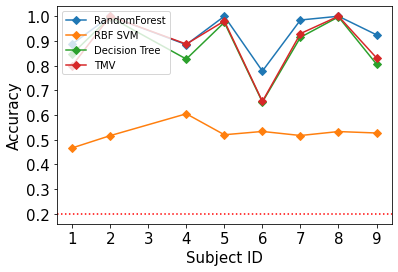

In [7]:
x_axis = subject_id
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots()

for y_name in y_names:
    y_accuracy = []
    for key in score_dict:
        if y_name == "TMV":
            y_accuracy.append(score_dict[key][y_name])
        else:
            y_accuracy.append(score_dict[key][y_name][0])
    ax.plot(x_axis, y_accuracy, marker='D', label = y_name)
ax.legend(loc='upper left')
plt.xlabel('Subject ID', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.axhline(y=0.2, color='r', linestyle=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()